# Setup the mongodb by typing below in the cmd
mongod --dbpath=C:/database_mongo

# Part One: import data

In [1]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import date
import time
%matplotlib inline
matplotlib.style.use('ggplot')
client = MongoClient()
"""
TBS: CODES TO CREATE DB/COLLECTIONS
currently using a establised one : test.edxsam
"""# By default: localhost 27017
db = client.test
cursor = db.edxsam.find({})#
mong = []
for document in cursor:
    mong.append(document) #Which gives a list of dictionaries

In [2]:
df = pd.DataFrame.from_dict(mong) #Each dictionary has the same fields so easy to pd
print(df.columns)
len(df.columns)

Index([u'_id', u'_type', u'abuse_flaggers', u'anonymous',
       u'anonymous_to_peers', u'at_position_list', u'author_id',
       u'author_username', u'body', u'child_count', u'closed',
       u'comment_count', u'comment_thread_id', u'commentable_id', u'context',
       u'course_id', u'created_at', u'depth', u'endorsed', u'endorsement',
       u'historical_abuse_flaggers', u'last_activity_at', u'parent_id',
       u'parent_ids', u'pinned', u'sk', u'thread_type', u'title',
       u'updated_at', u'visible', u'votes'],
      dtype='object')


31

* We did nothing about the `votes` column (which still saves data as JSON) for we are not using it at the moment. Will probably deal with it later.   

## Data Must-Knows
The followings are fields that needs to be addressed, for either they are important or the names are not self-explanatory enough.  

#### Comments&CommentThreads Shared  
**`_id`** : Unique ID for this collection; Monotonically increasing; first four bytes are a timestamp  
**`_type`**:Comment/Comment_Thread  
**`author_id`**:User ID as in `auth_user.sql`  
**`votes`**:  
_up = list of User IDs that up-voted this comment or thread.  
down = (no longer used) list of User IDs that down-voted this comment or thread.  
up_count = total upvotes received.  
down_count = No longer used. Total downvotes received.  
count = total votes cast.  
point = net vote, now always equal to up_count._  

#### CommentThreads
**`comment_count`** :All comments&Replies excluding the thread itself  
**`commentable_id`**: A component, e.g.“d9f970a42067413cbb633f81cfb12604”; or a top-level, in format`i4x-{org}-{course}-{run}-{name}`  
**`last_activity_at`**: UTC timestamp  
**`thread_type`**: "question" or "discussion"  
**`pinned`**: If a CommentThread is pinned on the top (mostly administrator posts)  
#### Comment 
**`comment_thread_id`**: comment_thread_id it is responding to  
**`abuse_flaggers`**,**`historical_abuse_flaggers`**:IDs of thoes who report "misuse"  
**`parent_id`**: Replying to a comment (depth 1)  
**`parent_ids`**: all parent ids (any depth)  
**`sk`**: A randomly generated number that drives a sorted index to improve online
performance.  
#### No longer used:
`at_position_list`
**???**
`context`;`depth`

## Questions Interested in
We come up with new ideas as we go. But here are the questions we have at the moment.
* How many users posted comments? [USER & Comments]
    - Age, district, education background, language they use, certificates. Who are thoes people who ask questions?  
    - Grades, active forum users get higher grades?
    - Note: have to exclude course staff comments

* How many Comments/CommentThreads[Comments]
    - How many CommentThreads are there   
    - Of all CommentThreads how many of thoes are questions/comments? Do questions get more attention
    
* When do students post questions [Comments & USER & Course]
    - Time series features? General trend and patterns?
    - Whether students tend to post more near deadlines
    - Whether course administrator/tutors' posts encourage more replies from students

* User communications: do people build connections through forum? Are they "similar" in some way or another? [USER & USER]

* _Not sure:_ Text Mining Question: what kind of posts get more replies?

# Part Two: continue yesterday's work

## How many active users

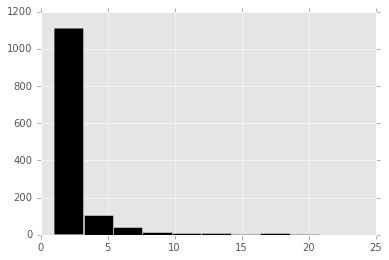

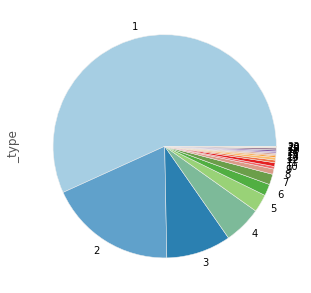

In [14]:
# Histogram
%matplotlib inline
matplotlib.style.use('ggplot')
grouped=df.groupby('author_id')
a = grouped.agg('count').sort_values('_id')['_id']
g = grouped.agg('count').sort_values('_id').groupby('_id').agg('count')['_type']
plt.hist(a,color='k')
plt.show()
# Pie-Chart
g.plot.pie(figsize=(5, 5),colormap='Paired')
#I personally would recommend define "active" by "comments more than or equals 5" based on the pie.

## Comments vs. Comment Threads

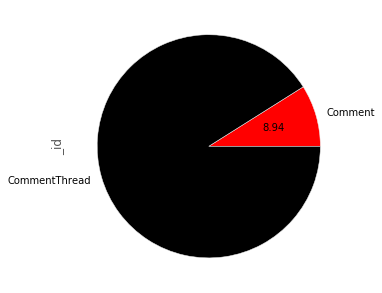

In [17]:
"""How Many Threads&Comments"""
comment_type=df.groupby('_type')
comment_type = comment_type.agg('count').sort_values('_id')['_id']
comment_type.plot.pie(figsize=(5, 5),autopct='%.2f',colors=['r','k'])

Suprising in someways, there are over 6 times more comment threads than comments. Many threads never get replied to. 

#### How many comment threads are questions?

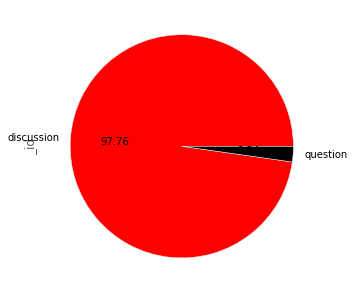

In [19]:
ct=df[df['_type']=='CommentThread']
group_ct=ct.groupby('thread_type').agg('count')['_id']
group_ct.plot.pie(figsize=(5, 5),autopct='%.2f',colors=['r','k'])

Interestingly, most of the threads are "discussion" threads instead of "question" posts.
#### How many responses to each type

Responding to Threas: Question vs. Discussion
thread_type  comment_count
discussion   0                2504
             1                 131
             2                  15
             3                   2
             4                   1
             8                   2
             10                  1
             12                  1
question     0                  38
             1                  12
             2                   6
             3                   3
             12                  1
             13                  1
Name: _id, dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D52ABA8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D626A58>], dtype=object)

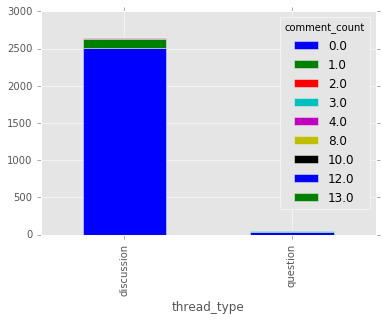

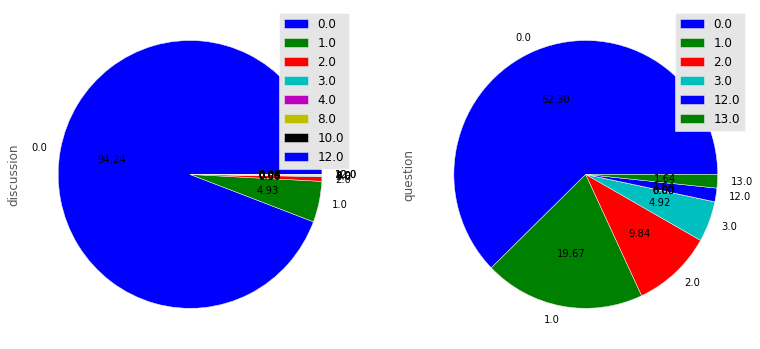

In [20]:
group_ct2=ct.groupby([ct['thread_type'],ct['comment_count']]).agg('count')['_id']
print("Responding to Threas: Question vs. Discussion")
print(group_ct2)
group_ct2.unstack('comment_count').plot.bar(stacked=True)
group_ct2.unstack('thread_type').plot.pie(subplots=True,figsize=(13, 6),autopct='%.2f')

**What questions/discussions got more response? Might be an NLP problem**

## When do People Post Questions

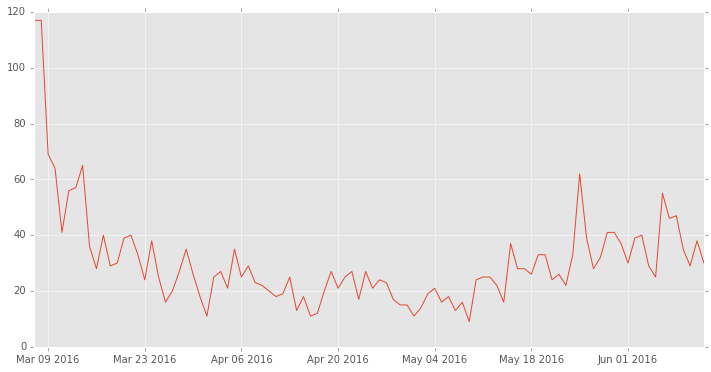

In [21]:
"""NOTE: Need to further understand PYTHON SERIES,GROUPBY to know why sth works """
datedis = df.groupby(df["created_at"].dt.date).agg('count')["_id"] 
%matplotlib inline
plt.figure(figsize=(12,6)) # Set graph size
plt.plot(datedis)
plt.show()

General trend: goes down  
Some ups and downs.  
**Further: what questions to ask and what data to integrate with**  
Mark deadline [_with what?_]  
Mark staff [_with userdata_]  
Hist by week [_time series_]  
Staff vs. None Staff [_with userdata_]  
Audit vs. Certificate[_with userdata_]  
Time Zone (Not currently for it may be interesting by not directly relavant)  

## How many distinct authors are there? Out of how many users?

In [29]:
df.head(3)

,_id,_type,abuse_flaggers,anonymous,anonymous_to_peers,at_position_list,author_id,author_username,body,child_count,...,last_activity_at,parent_id,parent_ids,pinned,sk,thread_type,title,updated_at,visible,votes
0,575d1babf3ea610511000310,Comment,[],False,False,[],1830339,ShirYee,I do agree that validating the data is the 1st...,0,...,NaN,NaN,[],NaN,575d1babf3ea610511000310,NaN,NaN,2016-06-12 08:22:03.672,True,"{u'count': 0, u'point': 0, u'down_count': 0, u..."
1,575cb2bf35c79c0556000320,Comment,[],False,False,[],6734413,ericakewang,1. Strong knowledge in probability and statist...,0,...,NaN,NaN,[],NaN,575cb2bf35c79c0556000320,NaN,NaN,2016-06-12 00:54:23.968,True,"{u'count': 0, u'point': 0, u'down_count': 0, u..."
2,5759668f35c79c055600019b,Comment,[],False,False,[],10578239,RachaelMart,"Mannisha,\nI like to hold materials and to ref...",0,...,NaN,NaN,[],NaN,5759668f35c79c055600019b,NaN,NaN,2016-06-09 12:52:31.208,True,"{u'count': 0, u'point': 0, u'down_count': 0, u..."


In [33]:
df.columns

Index([u'_id', u'_type', u'abuse_flaggers', u'anonymous',
       u'anonymous_to_peers', u'at_position_list', u'author_id',
       u'author_username', u'body', u'child_count', u'closed',
       u'comment_count', u'comment_thread_id', u'commentable_id', u'context',
       u'course_id', u'created_at', u'depth', u'endorsed', u'endorsement',
       u'historical_abuse_flaggers', u'last_activity_at', u'parent_id',
       u'parent_ids', u'pinned', u'sk', u'thread_type', u'title',
       u'updated_at', u'visible', u'votes'],
      dtype='object')

## Fields exploration

In [73]:
df['_type'].describe()#2718 CommentThreads, 267 Comments

count              2985
unique                2
top       CommentThread
freq               2718
Name: _type, dtype: object

In [84]:
n = 0
for each in list(df['abuse_flaggers']):
    if each != []:
        print n
        print each
    n+=1
n

2340
[u'9806302']


2985

In [86]:
df.iloc[2340]['body'] #this one is a misuse

u'Was genuinely a beer tasting survey. Have no other recollection.'

In [94]:
len(df[df['anonymous']==False])#no one anonymous

2985

In [96]:
len(df[df['anonymous_to_peers']==False])#no one anonymous to peers

2985

In [98]:
n = 0
for each in list(df['at_position_list']):
    if each != []:
        print n
        print each
    n+=1
n
#all values in this field are empty

2985

In [99]:
df['author_id'].describe()#the most "active" one posts 23 comments in all

count        2985
unique       1312
top       6419117
freq           23
Name: author_id, dtype: object

In [100]:
df['author_username'].describe()#username and id are 1 to 1

count       2985
unique      1312
top       bparry
freq          23
Name: author_username, dtype: object

208
24
2
2


([<matplotlib.patches.Wedge at 0xc68d898>,
  <matplotlib.text.Text at 0xc23bbe0>])

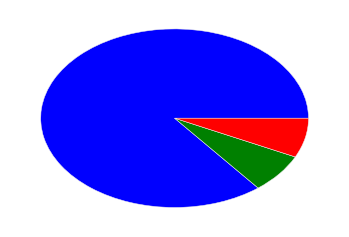

In [143]:
get_replied = df['child_count'].dropna()
len(get_replied)# there are 236 comments get replied
print df[df['child_count']==0]['_type'].count()
print df[df['child_count']==1]['_type'].count()
print df[df['child_count']==2]['_type'].count()
print df[df['child_count']==3]['_type'].count()
#among 267 comments, there are 208 get no reply, 24 get 1 reply, 2 get 2 replies and 2 get 3 replies.
matplotlib.style.use('ggplot')
plt.pie([24,2,2])

In [121]:
replies = df['parent_id'].dropna()
print len(replies)
print len(replies.unique())
#there are 34 replies to 28 distinct comments. 

34
28


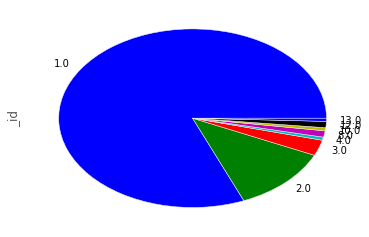

In [5]:
thread_cc = df['comment_count'].dropna()
df[df['comment_count']>0].groupby('comment_count').count()['_id'].plot.pie()
#out of 2985 only the 2718 CommentThread get comment_count but Comment doesn' have this attribution

In [6]:
df['comment_thread_id'].dropna().describe()

count                          267
unique                         176
top       56efe80881e07b0535000192
freq                            13
Name: comment_thread_id, dtype: object

In [7]:
df[df['_id']==df['comment_thread_id'][0]]['comment_thread_id']
#if the post is a commentthread, then it's 'comment_thread_id' is NaN

657    NaN
Name: comment_thread_id, dtype: object

In [8]:
df['commentable_id'].dropna().describe()
#I don't know what's this but it seems that only CommentThread have this attribution

count                                         2718
unique                                          24
top       75c719ca9391764e2738f870e494b364c3a9f873
freq                                           713
Name: commentable_id, dtype: object

In [9]:
df['context'].dropna().describe()#CommentThread ONLY

count       2718
unique         1
top       course
freq        2718
Name: context, dtype: object

In [10]:
df['course_id'].describe()

count                                  2985
unique                                    1
top       course-v1:ColumbiaX+DS101X+1T2016
freq                                   2985
Name: course_id, dtype: object

In [11]:
df['created_at'].describe()

count                           2985
unique                          2985
top       2016-06-12 08:52:45.196000
freq                               1
first     2016-03-07 01:13:31.685000
last      2016-06-12 22:03:25.106000
Name: created_at, dtype: object

In [12]:
df['depth'].describe()#what's this?

count    267.000000
mean       0.127341
std        0.333980
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: depth, dtype: float64

# Part Three: communication network exploration

In [3]:
map_comm = df[['_id','parent_id','author_id']].dropna()
dict_comm = {i:{'_id':str(map_comm.iloc[i]['_id']),'parent_id':str(map_comm.iloc[i]['parent_id']),
             'author_id':str(map_comm.iloc[i]['author_id'])} for i in range(map_comm.shape[0])}
################################
map_thread = df[['_id','comment_thread_id','author_id']].dropna()
dict_thread = {i:{'_id':str(map_thread.iloc[i]['_id']),
             'comment_thread_id':str(map_thread.iloc[i]['comment_thread_id']),
             'author_id':str(map_thread.iloc[i]['author_id'])} for i in range(map_thread.shape[0])}

In [4]:
comm_auth = df[df['_id'].isin(map_comm['parent_id'])][['_id','author_id']]
dict_auth_cm = {str(comm_auth.iloc[i]['_id']):str(comm_auth.iloc[i]['author_id'])
             for i in range(comm_auth.shape[0])}
##################################
thread_auth = df[df['_id'].isin(map_thread['comment_thread_id'])][['_id','author_id']]
dict_auth_th = {str(thread_auth.iloc[i]['_id']):str(thread_auth.iloc[i]['author_id'])
             for i in range(thread_auth.shape[0])}

In [5]:
from collections import Counter
edge_comm = []
for each in dict_comm:
    edge_comm.append((dict_comm[each]['author_id'],dict_auth_cm[dict_comm[each]['parent_id']]))
graph_map_cm = Counter(edge_comm)
ids_cm = set([x for item in graph_map_cm.keys() for x in item ])
index_ids_cm = {x:i for i,x in enumerate(ids_cm)}# 36 authors
##################################
edge_thread = []
for each in dict_thread:
    edge_thread.append((dict_thread[each]['author_id'],
                        dict_auth_th[dict_thread[each]['comment_thread_id']]))
graph_map_th = Counter(edge_thread)
ids_th = set([x for item in graph_map_th.keys() for x in item ])
index_ids_th = {x:i+36 for i,x in enumerate(ids_th)}#302 authors
index_ids = {x:i for i,x in enumerate(ids_cm.union(ids_th))}
#302 authors(which is reasonable because every comment is under some thread)

## Comments network

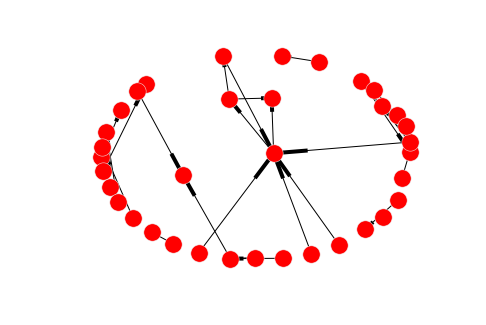

In [6]:
import networkx as nx
DG = nx.DiGraph()
l1 = [(index_ids[graph_map_cm.keys()[i][0]],index_ids[graph_map_cm.keys()[i][1]],
      float(graph_map_cm[graph_map_cm.keys()[i]])) 
      for i in range(len(graph_map_cm))]
DG.add_weighted_edges_from(l1)
nx.draw(DG)  

## CommentThreads network

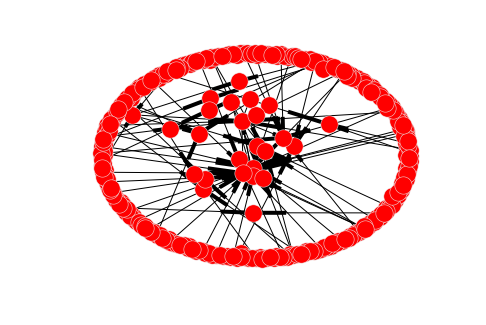

In [7]:
import networkx as nx
DG = nx.DiGraph()
l2 = [(index_ids[graph_map_th.keys()[i][0]],index_ids[graph_map_th.keys()[i][1]],
      float(graph_map_th[graph_map_th.keys()[i]])) 
      for i in range(len(graph_map_th))]
DG.add_weighted_edges_from(l2)
nx.draw(DG)  

## Overall network

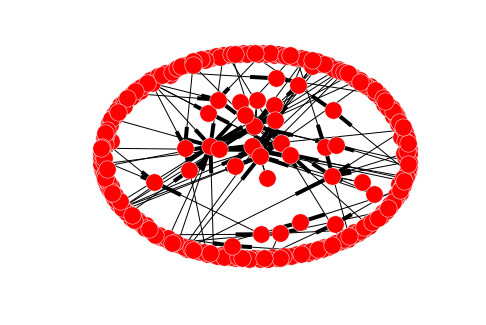

In [8]:
import networkx as nx
DG = nx.DiGraph()
l = l1+l2
DG.add_weighted_edges_from(l)
nx.draw(DG)  

### TO DO
* optimize code
* disconnected components
* in/out-degree
* k-shell
* clusters     
      
* post time, gender, location, etc of the center nodes/authors